## Analysis of Funnel Metadynamics Simulations

***

**Author**:       Afroditi Maria Zaki  
**Affiliation**:  SBCB,  Unversity of Oxford

**Last updated**: 02.03.2022 

## Funnel Metadynamics

***

* A binding free energy method that explores the ligand binding process from its solvated state to the final binding site.

* The exploration of the space of the selected degrees of freedom (Collective Variables, CVs) is enhanced by applying a bias potential constructed as a sum of Gaussian functions.

*  The restraint potential is the combination of a cone restraint, that includes the ligand binding site, and a cylindrical restraint that is directed towards the solvent.

* The method gives an accurate calculation of the absolute protein-ligand binding energy.

* It allows the identification of the ligand binding mode and potentially alternative binding modes.

* Finally, it provides an insight into the dynamics of ligand binding mechanism.


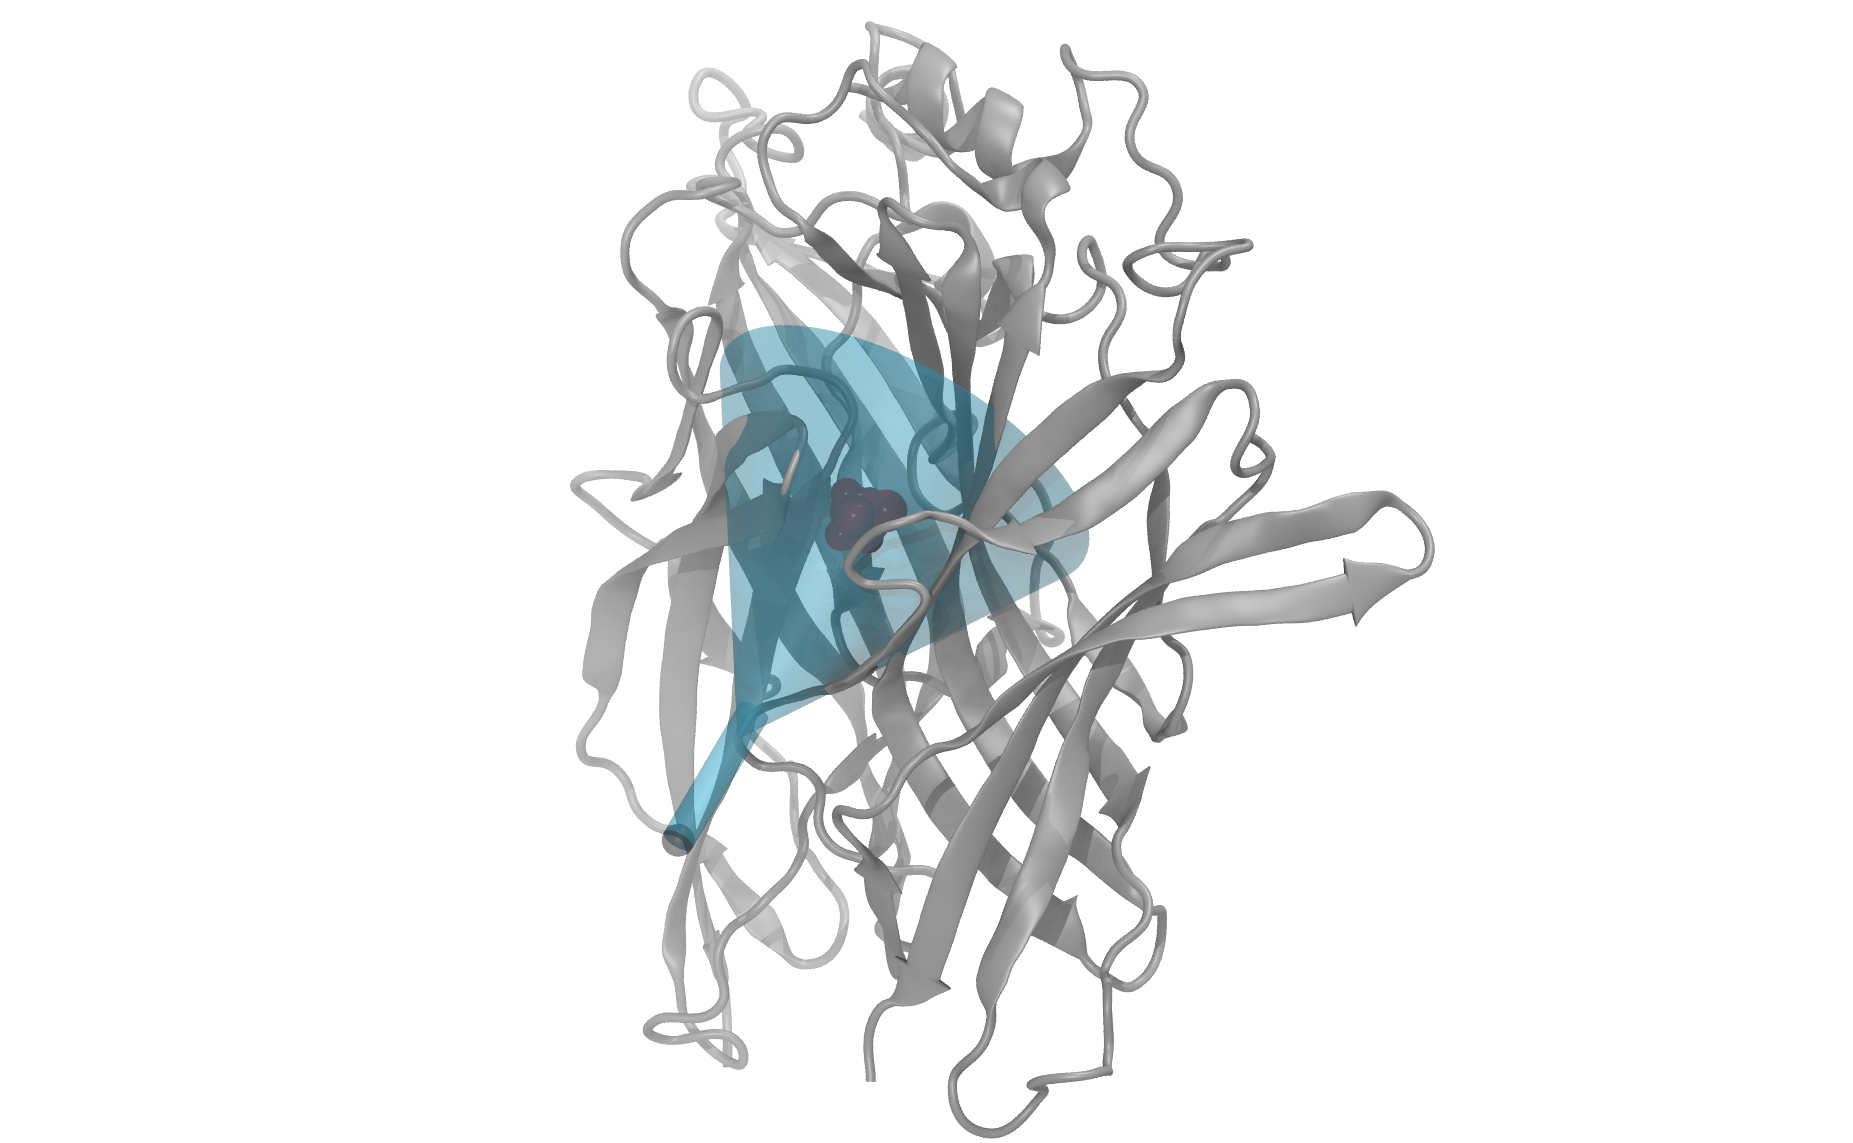

> This jupyter notebook can be used for the analysis of Funnel Metadynamics simulation trajectories generated  
with the use of [GROMACS](https://www.gromacs.org/) patched with [PLUMED](https://www.plumed.org/doc-v2.4/user-doc/html/index.html).
<br>
> **Simulations performed with**:     
<br>
> GROMACS version 2020.4  
> PLUMED version 2.7.2

## Import packages
***

Import here all the packages that will be required for the analysis.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import sys
import MDAnalysis as mda
import math
from numpy.linalg import norm
#from color_lightness import adjust_lightness
print("*********************************\n Required packages are imported \n*********************************")

## Define colours
***


The colours and colourmaps of matplotlib can be found here:
* [matplotlib colours](https://matplotlib.org/3.1.0/gallery/color/named_colors.html)
* [matplotlib colourmaps](ttps://matplotlib.org/stable/tutorials/colors/colormaps.html)

In addition, I have created two colour dictionaries with favourite colours.

**Colour dictionaries**: 
* col1 - Wes Anderson
* col2 - colorbrewer colorblind-safe

In [ ]:
col1 = {'red': (0.58, 0.29, 0.31), 'yellow': (0.76, 0.56, 0.00), 'blue': (0.38, 0.54, 0.60), 'green': (0.43, 0.60, 0.48)}
col2 = {'red': '#e66101' , 'orange': '#fdb863', 'lavender': '#b2abd2', 'purple': '#5e3c99'}
print("*********************************\n Colour dictionaries are defined \n*********************************")

## Path of simulation files
***
In the `path`, there are subdirectories containing the individual walker simulation data, called `1, 2, ..., n_walkers`


In [ ]:
path=f"/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/MW/8MW/"
print("The data files are in this location:\n\n",path)

## Compute Free Energy Profiles from HILLS file
*** 
* Execute the ```free_energy.sh``` that uses the sum_hills tool from PLUMED to read the HILLS file and calculate the free energy profile.
* Execute also the ```convergence.sh``` script that uses the sum_hills tool from PLUMED to to read the HILLS file and calculate the free energy profile for 100-ns intervals in order to monitor convergence.

In [ ]:
#Go to the directory of the run
%cd {path}/HILLS

#Remove previously generated energy files
%rm fes*

#Execute free energy script
!bash free_energy.sh

#Execute convergence script
!bash convergence.sh

## CV1 space sampling with time
***
Plot of the ligand CoM position along the funnel axis, *p* (CV1) as a function of the simulation time. The shaded region denotes the bound state. 

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=8

#Plot parameters
step=10    #Only read every nr-th data point
xstep=100
ymin, ymax, ystep=-5, 25, 5
color='darkgray'
facecolor=col2['lavender']

#### Read data files

Read the COLVAR files, where the time and the CV1 are saved.

In [ ]:
#Introduce the dictionaries that will store the CVs.
d_Time={}
d_cv={}

#Define path of simulation data  
for run in range(1, n_walkers+1):
    #Monitor calculation progress
    walker=int(f"{run}")-1
    print("Walker: ", walker)
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 0]/1000
    #Read CVs and convert to Angstrom
    d_cv[f"cv{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 1]*10
    
print("***************************\n Data files have been read \n***************************")

#### Plot

Plot the CV1 space that has been sampled during the Funnel MetaD simulation in one figure

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(10, 3))

#Read the data to find the lower and upper limits of the x-axis
xmin=float("{0:.1f}".format(np.amin(d_Time[f"Time{1}"])))              
xmax=float("{0:.1f}".format(np.amax(d_Time[f"Time{1}"])))

for i, ax in enumerate(fig.axes):
    line=ax.plot(np.array(d_Time[f"Time{i+1}"])[::step], np.array(d_cv[f"cv{i+1}"])[::step], linewidth=0.5, color=color)
    ax.set_xlim([xmin-10, xmax+10])
    ax.set_xticks(np.arange(0, int(xmax+10), xstep))
    ax.set_xticklabels(np.arange(0, int(xmax+10), xstep), fontsize='small')
    ax.set_ylim([ymin, ymax])
    ax.set_yticks(np.arange(ymin, ymax, ystep))
    ax.set_yticklabels(np.arange(ymin, ymax, ystep), fontsize='small')
    ax.text(0.5, 0.9, f"Walker{i+1}", ha='center', transform=ax.transAxes, fontsize='small')
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')
    ax.axhspan(-3.0, 3.0, facecolor=facecolor, alpha=0.3)

fig.add_subplot(111, frameon=False)
#Hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='medium')
plt.ylabel('Position along funnel axis [$\AA$]', fontsize='medium')
plt.text(1.36, 0.58, "unbound", ha='center', transform=ax.transAxes)
plt.text(1.36, 0.21, "bound", ha='center', transform=ax.transAxes)

#Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(right=0.85, wspace=0.05, hspace=0.0)

#Save figure in the ANALYSIS directory as a .png image
#Make sure that there is an ANALYSIS directory in your path
plt.savefig(f"{path}/ANALYSIS/position_all.png", bbox_inches='tight', dpi=600)

#Show figure in Jupyter Notebook
plt.show()

## Binding Events
***


> <font color='red'>**This gives wrong results, needs to be fixed before is used!**</font>

A ligand binding event is considered to occur when ligand positional criteria are satisfied. In particular, based on the FES figure, the free energy well that corresponds to the binding pocket can be described by the values of the two CVs, lp and ld. When the ligand CoM is within both the limits of the CVs that correspond to the limits of the binding pocket, a binding event is registered. 

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=8

#Plot parameters
step=10    #Only read every nr-th data point
xstep=250
ymin, ymax, ystep=-5, 30, 5
color='darkgray'
facecolor=col2['lavender']
#Define colormap, step and legend properties
cmap=plt.cm.Purples
#cmap=plt.cm.Reds
# props = dict(facecolor=adjust_lightness('purple', 3.95))

#### Compute the ligand binding events as a function of simulation time

In [ ]:
#Define the positional criteria that describe a binding event of the ligand at the known binding pocket
lowerlimitlp, upperlimitlp=-3.0, 3.0
lowerlimitld, upperlimitld=0.0, 4.0

#Introduce the dictionaries that will store the CVs.
d_Time={}
d_lp={}
d_ld={}
d_data={}

#Define path of simulation data  
for run in range(1, n_walkers+1):
    walker=int(f"{run}")-1
    print("Walker: ", walker)
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 0]/1000
    #Read CVs and convert to Angstrom
    d_lp[f"lp{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 1]*10
    d_ld[f"ld{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 2]*10
    
    
    #Compute the ligand binding events as a function of time and save in data dictionary
    bind=[]
    for x, y, z in zip(d_lp[f"lp{run}"], d_ld[f"ld{run}"], d_Time[f"Time{run}"]):
    # print(x, y, z)
        if lowerlimitlp<=x<=upperlimitlp and lowerlimitld<=y<=upperlimitld:
            bind.append((True)) 
#             print(z, True)
        else:
            bind.append((False))
#             print(z, False)  

    data_old=np.full(len(d_Time[f"Time{run}"]), bind, dtype=bool)
    d_data[f"data{run}"]=np.reshape(data_old, (-1, len(d_Time[f"Time{run}"])))
    
print("***************************\n Data files have been read \n***************************")

#### Plot

Plot the binding events for all the walkers in one figure

In [ ]:
%matplotlib notebook

#Give number of rows and columns for the figure and figure size
fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(10, 3))

#Read the data to find the lower and upper limits of the x-axis
xmin=float("{0:.1f}".format(np.amin(d_Time[f"Time{1}"])))              
xmax=float("{0:.1f}".format(np.amax(d_Time[f"Time{1}"])))

#Loop over the data for each walker and plot in a subplot
for i, ax in enumerate(fig.axes):
    image=ax.imshow(np.array(d_data[f"data{i+1}"]), aspect='auto', interpolation=None, cmap=cmap)
    ax.set_xticks(np.arange(xmin*1000, (xmax*1000)+1, xstep*1000))
    ax.set_xticklabels(np.arange(int(xmin), int(xmax)+1, xstep), fontsize='small')
    ax.set_xlim(xmin*1000, xmax*1000)
    ax.tick_params(axis='x', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')
    ax.tick_params(axis='y', left=False, right=False, which='major', labelbottom=True, labeltop=False, labelleft=False, labelright=False, direction='in')
    ax.set_title(f"Walker{i+1}", fontsize='small')
    
#Add common x- and y- axes for all the subplots  
fig.add_subplot(111, frameon=False)
#Hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='medium')
plt.ylabel('Binding Events', fontsize='medium')

#Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#Define the space between subplots and the space from the borders
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
#fig.tight_layout()

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/bind_bool_all.png", bbox_inches='tight', dpi=600)

#Show figure in Jupyter Notebook
plt.show()

## Gaussian Height
***

The gaussian height (W) for each multiple walker (MW) as a function of the simulation time.  
It is expected that the Gaussian height decreases with simulation time.

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=8

#Convert kj/mol to kcal/mol 
kj2kcal=4.1868

#Plot parameters
step=1
xstep=250  #xmin and xman will be read from HILLS file
ymin, ymax, ystep=0.0, 0.6, 0.1
yticklabels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
color=col2['lavender']

#### Read data files

In [ ]:
#Introduce the dictionaries that will store the Gaussian Heights
d_Time={}
d_gh={}

#Loop over the HILLS file for each walker to read the Gaussian Heights
for run in range(0, n_walkers):
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/HILLS/HILLS.{run}", comments="#")[:, 0]/1000
    #Read Gaussian Heights and convert to kcal/mol
    d_gh[f"gh{run}"]=np.loadtxt(f"{path}/HILLS/HILLS.{run}", comments="#")[:, 5]/kj2kcal
    
print("***************************\n Data files have been read \n***************************")

#### Plot

Plot the Gaussian height as a function of time for a well-tempered Metadynamics simulation

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(10, 3))
              
#Read the data to find the lower and upper limits of the x-axis
xmin=float("{0:.1f}".format(np.amin(d_Time[f"Time{0}"])))              
xmax=float("{0:.1f}".format(np.amax(d_Time[f"Time{0}"])))

for i, ax in enumerate(fig.axes):
    line=ax.plot(np.array(d_Time[f"Time{i}"])[::step], np.array(d_gh[f"gh{i}"])[::step], linewidth=1, color=color)
    ax.set_xlim(xmin-10, xmax+10)
    ax.set_xticks(np.arange(xmin, xmax+10, xstep))
    ax.set_xticklabels(np.arange(int(xmin), int(xmax)+10, xstep), fontsize='small')
    ax.set_ylim([ymin-0.1, ymax+0.1])
    ax.set_yticks(np.arange(ymin, ymax+0.1, ystep))
    ax.set_yticklabels(yticklabels, fontsize='small')
    ax.text(0.5, 0.85, f"Walker{i+1}", transform=ax.transAxes, ha='center', fontsize='small')
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')

fig.add_subplot(111, frameon=False)
#Hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='medium')
plt.ylabel('Gaussian Height [kcal/mol]', fontsize='medium')

#Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.1, right=0.8, wspace=0.04, hspace=0.04)

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/gaussian_height_all.png", bbox_inches='tight', dpi=600)

#Show figure in Jupyter Notebook
plt.show()

## CV Space Sampling with time
***
2D plot of the sampling of the two collective variables (CoM ligand position along the funnel axis,*p* and CoM ligand distance from the funnel axis, *d*) as a function of the simulation time, for all walkers.

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=8

step=100 #Only read data every nr-th data point

#Define colormap
cmap=plt.cm.Purples

#Plot parameters
xmin, xmax, xstep=-5, 25, 5
ymin, ymax, ystep=0, 15, 5
color=col2['lavender']

#### Read data files

In [ ]:
#Introduce the dictionaries that will store the CVs.
d_Time={}
d_lp={}
d_ld={}

#Define path of simulation data  
for run in range(1, n_walkers+1):
    walker=int(f"{run}")-1
    print("Walker: ", walker)
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 0]/1000
    #Read CVs and convert to Angstrom
    d_lp[f"lp{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 1]*10
    d_ld[f"ld{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 2]*10

print("***************************\n Data files have been read \n***************************")

#### Plot

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(10, 3))

for i, ax in enumerate(fig.axes):
    sctr=ax.scatter(np.array(d_lp[f"lp{i+1}"])[::step], np.array(d_ld[f"ld{i+1}"])[::step], s=0.3, c=np.array(d_Time[f"Time{i+1}"])[::step], alpha=0.7, cmap='PuOr')
    ax.set_xticks(np.arange(xmin, xmax, xstep))
    ax.set_xticklabels(np.arange(xmin, xmax, xstep), fontsize='small')
    ax.set_yticks(np.arange(ymin, ymax, ystep))
    ax.set_yticklabels(np.arange(ymin, ymax, ystep), fontsize='small')
    ax.text(0.5, 0.85, f"Walker{i+1}", ha='center', transform=ax.transAxes, fontsize='small')
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')

    
fig.add_subplot(111, frameon=False)
#Hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Position along funnel axis [$\AA$]', fontsize='medium')
plt.ylabel('Distance from funnel axis [$\AA$]', fontsize='medium')


#Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.1, right=0.8, wspace=0, hspace=0)

#Define colorbar parameters
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar=plt.colorbar(sctr, cax=cbar_ax)
cbar.set_label("Time [ns]", fontsize='medium', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(direction='in', labelsize='small')

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/cv_space_sampling_all.png", bbox_inches='tight', dpi=600)

#Show figure in Jupyter Notebook
plt.show()

## Free Energy profile along *p*
Plot the Free Energy profile as a function of one of the collective variables, for a WT Metadynamics simulation.  
Here, the Free Energy is computed with respect to the ligand position along the funnel axis, *p* (CV1).

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=8

#Convert kJ/mol to kcal/mol
kj2kcal=4.1868

#Define colormap
cmap=plt.cm.Purples

#Plot parameters
color='purple'
linewidth=2.5

#### Read data files and compute free energy of unbound region

In [ ]:
#Read the free energy file
xdata=np.loadtxt(f"{path}/HILLS/fes-lp.dat")[:, 0]*10
ydata=np.loadtxt(f"{path}/HILLS/fes-lp.dat")[:, 1]/kj2kcal

#Calculate the free energy of the unbound region
data=[]
for i,j in zip(xdata,ydata):
    if i>=19.0 and i<=23.0:
        data.append((j))
        
fe_unbound=np.array(data)
fe=np.mean(fe_unbound)
correction=-3.86
fe_corrected=fe+correction

print("The free energy value at the unbound region is", round(np.mean(fe_unbound), 2),"±", round(np.std(fe_unbound), 2))
print("The corrected binding free energy is", round(fe_corrected, 2), "kcal/mol")




#### Plot

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(1, figsize=(6, 6))

ax.plot(xdata, ydata, color=color, linewidth=linewidth)
ax.set_xlim([-5, 22.5])
ax.set_xticks(np.arange(-5, 24, 5))
ax.set_xticklabels(np.arange(-5, 24, 5), fontsize='large')
ax.set_ylim([-1, 50])
ax.set_yticks(np.arange(0, 15, 1))
ax.set_yticklabels(np.arange(0, 15, 1), fontsize='large')
ax.set_xlabel('Position along funnel axis [$\AA$]', fontsize='large')
ax.set_ylabel('Free Energy [kcal/mol]', fontsize='large')
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in')
ax.axvline(x=15, linestyle='--', linewidth=2.0, color='darkgray')
ax.text(0.275, 0.85, "Bound Region", transform=ax.transAxes)
ax.text(0.755, 0.85, "Unbound Region", transform=ax.transAxes)
ax.hlines(y=fe_corrected, xmin=19.5, xmax=22.55, linewidth=2.5, color=col2['purple'], ls='dashed')
ax.arrow(20, fe-0.2, 0.1, -3.4, lw='1.0', color='darkblue', head_width = 0.5, head_length = 0.5, length_includes_head=True)
ax.arrow(21, fe-0.2, 0.1, -3.4, lw='1.0', color='darkblue', head_width = 0.5, head_length = 0.5, length_includes_head=True)
ax.arrow(22, fe-0.2, 0.1, -3.4, lw='1.0', color='darkblue', head_width = 0.5, head_length = 0.5, length_includes_head=True)

plt.tight_layout() # otherwise the right y-label is slightly clipped

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/fes.png", bbox_inches='tight', dpi=600)

#Show figure in Jupyter Notebook
plt.show()

## Monitor convergence of BFES

### 1. Plot the evolution of the BFES for regular intervals during the simulation

The lowest energy minimum corresponds to the bound state and is set to a free-energy value equal to 0 kcal/mol.  
Convergence is achieved when the overall shape of the BFES does not change significantly, and for the unbound region, the BFES is flat suggesting that the system visits multiple isoenergetic states when it is not interacting with the receptor.


#### User-defined parameters

In [ ]:
kj2kcal=4.1868
#Free energy is computed every 100000 ps for a 1000000-ps simulation
start, stop, step=100000, 1000000, 100000

#Plot parameters
xmin, xmax, xstep=-5, 24, 5
ymin, ymax, ystep=0, 13, 1

#### Read data files

In [ ]:
d_lp={}
d_fe={}
n=0
print("The free energy has been calculated at:\n")
for interval in range(start,stop+1,step):
    n+=1
    print(int(interval/1000), "ns")
    d_lp[f"{interval}"]=np.loadtxt(f"{path}/HILLS/CONVERGENCE/{interval}/fes-lp.dat", comments="#")[:, 0]*10
    d_fe[f"{interval}"]=np.loadtxt(f"{path}/HILLS/CONVERGENCE/{interval}/fes-lp.dat", comments="#")[:, 1]/kj2kcal

print("***************************\n Data files have been read \n***************************")

#### Plot

Plot the Free Energy profile as a function of the collective variable for a WT Metadynamics simulation

In [ ]:
fig, ax = plt.subplots(1, figsize=(6, 6))


plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.plasma_r(np.linspace(0, 1, n))))


for i in range(0, n):
    line=ax.plot(np.array(d_lp[f"{(i+1)*step}"]), np.array(d_fe[f"{(i+1)*step}"]), linewidth=2.5, label=f"{int((i+1)*step/1000)} ns")
    ax.set_xlim([xmin, xmax-1.5])
    ax.set_xticks(np.arange(xmin, xmax, xstep))
    ax.set_xticklabels(np.arange(xmin, xmax, xstep), fontsize='large')
    ax.set_ylim([ymin-1, ymax])
    ax.set_yticks(np.arange(ymin, ymax, ystep))
    ax.set_yticklabels(np.arange(ymin, ymax, ystep), fontsize='large')
    ax.set_xlabel('Ligand position along funnel axis [$\AA$]', fontsize='large')
    ax.set_ylabel('Free Energy [kcal/mol]', fontsize='large')
    ax.legend(loc=4, ncol=2, fontsize='small', fancybox=True, shadow=True)
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')
ax.axvline(x=15, linestyle='--', linewidth=2.0, color='darkgray')
ax.text(0.275, 0.85, "Bound Region", transform=ax.transAxes)
ax.text(0.755, 0.85, "Unbound Region", transform=ax.transAxes)

plt.tight_layout() # otherwise the right y-label is slightly clipped

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/fes-convergence.png", bbox_inches='tight', dpi=600)

#Show figure in Jupyter Notebook
plt.show()

### 2. Plot $\Delta$G$_B$ vs Time

* From the BFES, one can identify the ligand binding mode as the lowest free-energy minimum and compute the absolute protein–ligand binding free energy $\Delta$G$_b^0$ using the following formula:

$$\Delta G_B^0=-k_BTln(C^0K_b)$$

Where $C_0$ is the standard concentration of 1 M for all reacting molecules; $k_B$ is the Boltzmann constant; $T$ is the temperature of the system; and $K_b$ is the equilibrium binding constant obtained from the free-energy difference between the bound and unbound state. 

* The $\Delta$G$_B^0$ is calculated every 100 ns to assess the convergence.
* It is computed as the difference between the bound state and the isoenergetic values in the unbound region.
* It needs to be corrected for the effects of the restraining potential (which only affects the free energy of the unbound region.)
* The correction for the cylindrical restraint is calculated as:
***

$$ -\frac{1}{\beta}\ln\left( \pi{R_{cyl}}^2C_0 \right)$$
 
***

#### User-defined parameters

In [ ]:
ymin, ymax, ystep=-8, 2, 1

#### Compute the corrected free energy of binding at regular intervals

In [ ]:
correction=-3.86
n=0
data=[]
print("The corrected free energy of binding is:\n")
for interval in range(start,stop+1,step):
    bfe=[]
    n+=1
    a=np.loadtxt(f"{path}/HILLS/CONVERGENCE/{interval}/fes-lp.dat", comments="#")[:, 0]*10
    b=np.loadtxt(f"{path}/HILLS/CONVERGENCE/{interval}/fes-lp.dat", comments="#")[:, 1]/kj2kcal

    fes=np.column_stack((a,b))
    for i,j in zip(fes[:,0],fes[:,1]):
        if i>=18 and i<=22:
            binding_fe=-(j+correction)
            bfe.append((binding_fe))
    print(int(interval/1000), "ns", np.mean(np.array(bfe)), "kcal/mol")
    data.append((int(interval/1000), np.mean(np.array(bfe))))

#### Plot

In [ ]:
%matplotlib notebook

fig, (ax) = plt.subplots(1, figsize=(6, 6))

ax.plot(np.array(data)[:,0], np.array(data)[:,1], color='purple', alpha=1.0, lw=2.5)
ax.scatter(np.array(data)[:,0], np.array(data)[:,1], color='purple', alpha=1.0, edgecolors='face', marker="o", s=60)
ax.set_ylim(ymin, ymax)
ax.set_yticks(np.arange(ymin, ymax+1, ystep))
ax.set_yticklabels(np.arange(ymin, ymax+1, ystep), fontsize='medium')
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax.set_xlabel('Simulation Time [ns]', fontsize='large')
ax.set_ylabel('Free Energy [kcal/mol]', fontsize='large')
ax.text(0.8, 0.9, "Glycine", transform=ax.transAxes, fontsize='large')

fig.tight_layout()

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/deltag.png", bbox_inches='tight', dpi=600)

#Show figure in Jupyter Notebook
plt.show()

## Free Energy heatmap

#### User-defined parameters

In [ ]:
#Select colour map
cmap=plt.cm.plasma

#Control the range of the colorbar by removing data 
#outside of the range of interest
zmin=0
#zmax=int(Z_dat[0])
zmax=15
zstep=1.0
legend="Glycine"

#### Plot

Plot the Free Energy Surface as a function of the collective variables *p*, *d* for a Funnel Metadynamics simulation

In [ ]:
%matplotlib notebook

Z_dat=np.loadtxt(f"{path}/HILLS/fes.dat")[:, 2]/kj2kcal
X_dat=np.loadtxt(f"{path}/HILLS/fes.dat")[:, 0]*10
Y_dat=np.loadtxt(f"{path}/HILLS/fes.dat")[:, 1]*10


# Convert from pandas dataframes to numpy arrays
X, Y, Z, = np.array([]), np.array([]), np.array([])
for i in range(len(X_dat)):
        X = np.append(X, X_dat[i])
        Y = np.append(Y, Y_dat[i])
        Z = np.append(Z, Z_dat[i])

# create x-y points to be used in heatmap
xi = np.linspace(X.min(), X.max(), 1000)
yi = np.linspace(Y.min(), Y.max(), 1000)

# Z is a matrix of x-y values
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

# I control the range of my colorbar by removing data 
# outside of my range of interest
zmin=zmin
#zmax=int(Z_dat[0])
zmax=zmax
zi[(zi<zmin) | (zi>zmax)] = None
zstep=zstep
levels = np.arange(zmin, zmax, zstep)
#props=dict(facecolor='white', edgecolor='white', boxstyle='round')

fig, ax=plt.subplots(1, figsize=(6, 6))

# Create the contour plot
contourplot = plt.contourf(xi, yi, zi, 15, cmap=cmap,
                  levels=levels)

ax.set_xticks([-5, 0, 5, 10, 15, 20])
ax.set_xticklabels([-5, 0, 5, 10, 15, 20])
ax.set_ylim(-1, 11)
ax.set_yticks(np.arange(0, 11, 2))
ax.set_yticklabels(np.arange(0, 11, 2))
ax.set_xlabel('Position along funnel axis [$\AA$]', fontsize='large')
ax.set_ylabel('Distance from funnel axis [$\AA$]', fontsize='large')
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='large')
#ax.text(0.8, 0.9, f"{legend}", transform=ax.transAxes, fontsize='large', bbox=props)
ax.text(0.8, 0.9, f"{legend}", transform=ax.transAxes, fontsize='large')

fig.subplots_adjust(left=0.1, right=0.8, wspace=0, hspace=0)

#Define colorbar parameters
cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
cbar=plt.colorbar(contourplot, cax=cbar_ax)
cbar.set_label("Free Energy [kcal/mol]", fontsize='large', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(direction='in', labelsize='medium')

#plt.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig(f"{path}/ANALYSIS/fes-heatmap.png", bbox_inches='tight', dpi=600)

plt.show()

## Calculate and plot the RMSF of Loop C residues
***

Calculate and plot the Root Mean Square Fluctuations of the loop C amino acids.

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=4

#Give names of .tpr/.gro and .xtc/.trr files
gro="confout.gro"
xtc="traj_comp.xtc"
selection="resid 198-208 and name CA and bynum 0-3406"

#Plot parameters
res=("Cys198", "Thr199", "Lys200", "His201", "Tyr202", "Asn203", "Thr204", "Gly205", "Lys206", "Phe207", "Thr208")
ymin, ymax, ystep=0, 3.0, 0.5

#### Calculate the RMSF

In [ ]:
%matplotlib notebook
from MDAnalysis.analysis.rms import RMSF

#Introduce the dictionaries that will store the CV and the FE.
d_resid={}
d_rmsf={}


#Loop over the MWs simulations and calculate the principal loop C residues' RMSF values
for run in range(1, n_walkers+1):
    walker_path=f"{path}/{run}"
    %cd {walker_path}
    u=mda.Universe(gro, xtc)
#     rmsf=[]
#     time=[]
    loopC=u.select_atoms(selection)
    rmsfer = RMSF(loopC, verbose=True).run()
    d_resid[f"resid{run}"]=loopC.resnums
    d_rmsf[f"rmsf{run}"]=rmsfer.rmsf


#### Plot

Plot the RMSF of the amino acids that form loop C of the principal subunit.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(14, 3))


for i, ax in enumerate(fig.axes):
    sctr=ax.scatter(np.array(d_resid[f"resid{i+1}"]), np.array(d_rmsf[f"rmsf{i+1}"]), color='navy', marker='o', s=25)
    line=ax.plot(np.array(d_resid[f"resid{i+1}"]), np.array(d_rmsf[f"rmsf{i+1}"]), color='navy', linewidth=2.5)
    ax.fill_between(np.array(d_resid[f"resid{i+1}"]), 0, np.array(d_rmsf[f"rmsf{i+1}"]), alpha=0.2)
    ax.set_xlim(min(loopC.resnums)-1, max(loopC.resnums)+1)
    ax.set_xticks(np.arange(min(loopC.resnums), max(loopC.resnums)+1))
    ax.set_xticklabels(res, fontsize='7', rotation=60)
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(ymin, ymax+0.5, ystep))
    ax.set_yticklabels(np.arange(ymin, ymax+0.5, ystep), fontsize='small')
    ax.text(0.05, 0.85, f"Walker{i+1}", transform=ax.transAxes, ha='left')
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')
    ax.axvline(204, ls='dotted', c='black', lw=1.0)
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Loop C Residue', fontsize='large', labelpad=12)
plt.ylabel('RMSF [$\AA$]', fontsize='large')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.1, right=0.9, wspace=0, hspace=0)

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/loopC_RMSF.png", bbox_inches='tight', dpi=600)
plt.show()

## Loop C opening
***

The opening of loop C is monitored by measuring the distance between the Thr204 and the Arg65 C$\alpha$ atoms, which are located on loop C and $\beta$2 $\beta$ sheet, respectively.

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=8

walker=6
#Give names of .tpr/.gro and .xtc/.trr files
gro="confout.gro"
xtc="traj_comp.xtc"
#Define atom group selections
loopC_selection=f"resid 204 and name CA and bynum 0-3406"
bsheet_selection="resid 65 and name CA and bynum 3407-6813"

#Select a time window during which the ligand remains either bound or unbound
start, stop=20000, 25000

#Plot parameters
ymin, ymax, ystep=0, 3.0, 0.5
legend="Gly bound"

In [ ]:
from MDAnalysis.analysis.distances import dist

%cd {path}/{walker}
u=mda.Universe(gro, xtc)
distance=[]
time=[]
loopC=u.select_atoms(loopC_selection)
bsheet=u.select_atoms(bsheet_selection)

for ts in u.trajectory[start:stop]:
    distance.append((mda.analysis.distances.dist(loopC, bsheet, offset=0, box=None)))
    time.append((ts.time/1000))

time=np.array(time)
dist=np.array(distance)[:, 2]

           
#leg="Gly bound"
leg=legend
color_dict={'bound':'indianred', 'unbound':'cornflowerblue'}
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
                       
fig, (ax1) = plt.subplots(1,figsize=(6,6))


ax1.plot(time, dist, color=color_dict['bound'], linewidth=1.0)
# ax1.set_xticks([250, 260, 270, 280, 290, 300])
# ax1.set_xticklabels([250, 260, 270, 280, 290, 300])
# ax1.set_xticks([150, 160, 170])
# ax1.set_xticklabels([150, 160, 170])
ax1.set_yticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
ax1.set_yticklabels([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
ax1.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax1.set_xlabel('Time [ns]', fontsize='large')
ax1.set_ylabel('Loop C Distance [$\AA$]', fontsize='large')
#ax1.legend(leg, loc=2,  fancybox=True, shadow=True, fontsize='large')
#ax1.text(0.73, 0.92, f"{leg}", transform=ax1.transAxes, fontsize='large', bbox=props)

fig.tight_layout()

plt.savefig(f"{path}/ANALYSIS/loopC{run}_bound.png", bbox_inches='tight', dpi=600)

plt.show()

### Loop C opening distribution

The distribution of loop C opening is plotted. The previous cell needs to run first, as the calculation is performed there.

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=8

walker=3

#Give names of the topology (.tpr/.gro) and the trajectory (.xtc/.trr) files
topol="confout.gro"
traj="traj_comp.xtc"

#Define atom group selections
loopC_selection=f"resid 204 and name CA and bynum 0-3406"
bsheet_selection="resid 65 and name CA and bynum 3407-6813"

#Select two frame windows during which the ligand remains bound and unbound, respectively
#for an 100-ns simulation: 10000 frames if saving every 5000steps.
start_bound, stop_bound=38000, 43000
start_unbound, stop_unbound=20000, 25000

#Plot parameters

#### Calculation

In [ ]:
%matplotlib notebook

import pandas as pd
import seaborn as sns
from MDAnalysis.analysis.distances import dist

%cd {path}/{walker}
u=mda.Universe(topol, traj)
loopC=u.select_atoms(loopC_selection)
bsheet=u.select_atoms(bsheet_selection)
print(u.trajectory.n_frames)

#Select a time window during which the ligand remains bound 
start, stop=start_bound, stop_bound
distance=[]
time=[]
for ts in u.trajectory[start:stop]:
    distance.append((mda.analysis.distances.dist(loopC, bsheet, offset=0, box=None)))
    time.append((ts.time/1000))

time_bound=np.array(time)
dist_bound=np.array(distance)[:, 2]

#Select a time window during which the ligand remains unbound
start, stop=start_unbound, stop_unbound
distance=[]
time=[]
for ts in u.trajectory[start:stop]:
    distance.append((mda.analysis.distances.dist(loopC, bsheet, offset=0, box=None)))
    time.append((ts.time/1000))

time_unbound=np.array(time)
dist_unbound=np.array(distance)[:, 2]

################################

df_a = pd.DataFrame(data = dist_bound, columns=['distance']).assign(Glycine = 'Bound')
df_b = pd.DataFrame(data = dist_unbound, columns=['distance']).assign(Glycine = 'Unbound')

dist = pd.concat([df_a, df_b])
print(dist)

#### Plot

In [ ]:
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
nbins=100    

     
fig, (ax1) = plt.subplots(1,figsize=(6,6))

hist=sns.histplot(data=dist, x='distance', hue='Glycine', palette='rocket', kde=True, bins=nbins, legend=True, stat='density', alpha=0.7)
# ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
# ax1.set_xticklabels([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
# ax1.set_yticks([0.0, 0.2])
# ax1.set_yticklabels([0.0, 0.2])
ax1.tick_params(axis='both', bottom=True, top=True, right=True, left=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax1.set_xlabel('Loop C Distance [$\AA$]', fontsize='large')
ax1.set_ylabel('Probability density', fontsize='large')
# ax1.axvline(x=9.16, linestyle='--', linewidth=2.5, color=color_dict['bound'])
#ax1.axvline(x=9.094, linestyle='--', linewidth=2.0, color='darkgray')

fig.tight_layout()

plt.savefig(f"{path}/ANALYSIS/loopCdistr.png", bbox_inches='tight', dpi=600)
plt.show()

## Calculate the orientation of Glu157 with time
***

#### User-defined parameters

In [ ]:
#Give the number of multiple walkers
n_walkers=8

#Give names of the topology (.tpr/.gro) and the trajectory (.xtc/.trr) files
topol="confout.gro"
traj="traj_comp.xtc"

#Define atom group selections
ca_selection="resid 157 and name CA and bynum 0-3406"
cd_selection="resid 157 and name CD and bynum 0-3406"

#Plot parameters
color='plum'
step=100
xmin, xmax, xstep=0, 600, 200
ymin, ymax, ystep=90, 180, 30


#### Calculation 

To monitor the orientation of Glu157, the angle between the unit vector and the vector formed between Ca and Cd of Glu157 is computed, as a function of time.

In [ ]:
%matplotlib notebook

#Reference vector is the unit vector 
r0=np.array([0,0,1])
r0=r0.reshape(1,3)

def dotproduct(v1, v2):
    for a, b in zip(v1,v2):
        return sum(a*b)
# print(dotproduct(r0, r))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.degrees(math.acos(dotproduct(v1, v2) / (length(v1) * length(v2))))

#Introduce the dictionary that will store the angle values.
d_angle={}

for run in range(1, n_walkers+1):
    %cd {path}/{run}
    print("Walker", {run})
    print("Total number of frames is", u.trajectory.n_frames)
    u=mda.Universe(topol, traj)
    #Create atom groups for the Glu157 atoms that form the vector
    ca=u.select_atoms(ca_selection)
    cd=u.select_atoms(cd_selection)
    data=[]
    for ts in u.trajectory:
        ra=ca.positions
        rd=cd.positions
        r=rd-ra
        r=r.reshape(1,3)
        time=ts.time/1000
        data.append((time, angle(r0, r)))
    d_angle[f"{run}"]=np.array(data)
print(d_angle)

#### Plot

Plot the orientation of Glu157

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(14, 4))

for i, ax in enumerate(fig.axes):
    line=ax.plot(np.array(d_angle[f"{i+1}"])[:,0], np.array(d_angle[f"{i+1}"])[:,1], linewidth=0.5, color=color)
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(np.arange(xmin, xmax, xstep))
    ax.set_xticklabels(np.arange(int(xmin), int(xmax), xstep), fontsize='small')
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(ymin, ymax+10, ystep))
    ax.set_yticklabels(np.arange(ymin, ymax+10, ystep), fontsize='small')
    ax.text(0.5, 0.85, f"Walker{i+1}", transform=ax.transAxes, ha='center')
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')

                
fig.add_subplot(111, frameon=False)
#Hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='large')
plt.ylabel('Glu157 angle [degrees]', fontsize='large')


#Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.1, right=0.8, wspace=0.04, hspace=0.04)


#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/Glu157angle_all.png", bbox_inches='tight', dpi=600)

plt.show()

### Draw colorbar

In [ ]:
%matplotlib notebook
I_old = np.array(np.arange(200, 251))
I_new=np.reshape(I_old, (-1, 51))

fig, ax = plt.subplots()

im = ax.imshow(I_new, cmap=plt.cm.bwr_r)

#fig.colorbar(im, ax=ax)
#legend
cbar = fig.colorbar(im, ax=ax)

# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(['$0$','$1$','$2$','$>3$']):
#     cbar.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='center')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ns]', rotation=270, fontsize=14)


plt.savefig("/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/Gly2/colorbar.png", bbox_inches='tight', dpi=600)
plt.show()

## Gly-Thr204 Hydrogen Bond


Compute and plot the Hydrogen Bond formation between the ligand Gly and Thr204.

In [ ]:
#Import the MDAnalysis built-in tool for HB Analysis
import MDAnalysis
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

#Define the protein universe
#Note that when using this tool, it is recommended to include the .tpr file instead of the .gro file,
#because it contains bond information, required for the identification of donors and acceptors.
walker=1
protein = MDAnalysis.Universe(f"{path}/{walker}/topol.tpr", f"{path}/traj_comp.xtc")
GLX=protein.select_atoms('resname GLX and name O OXT')
THR=protein.select_atoms('resname THR and name HG1 and bynum 3129')
print(GLX.resnames, THR.names, THR.indices)

#print(len(protein.trajectory))
#Define the atom selections for the HB calculation.
#In this case, the THR hydrogens and the GLX oxygens, which act as the HB acceptors are specifically defined.
hbonds = HBA(universe=protein, hydrogens_sel='resname THR and name HG1 and bynum 3129', acceptors_sel='resname GLX and name O OXT')

print(hbonds)
# Perform the HB calculation
hbonds.run(start=0, stop=len(protein.trajectory), step=1)
    
# Plot the total number of GLX-THR HBs vs time
hbonds_time=hbonds.times
hbonds_data=hbonds.count_by_time()
print(hbonds_time)
# pyplot.plot(hbonds_time, hbonds_data, color='darkorange')
# pyplot.title("GLX-THR Hydrogen Bonds")
# pyplot.xlabel("Time [ps]")
# pyplot.ylabel("# Hydrogen Bonds")
# pyplot.show()

fig, (ax) = plt.subplots(1,figsize=(4,4))

ax.plot(hbonds_time, hbonds_data, color='cornflowerblue')
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize=small_font)
#ax.set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000])
ax.set_xticklabels([0, 50, 100, 150, 200, 250, 300], fontsize='small')
ax.set_xlabel("Time [ns]", fontsize='large')
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1], fontsize='small')
ax.set_ylabel("# Hydrogen Bonds", fontsize='large')

fig.tight_layout()

plt.savefig(f"{path}/ANALYSIS/glx_thr204_hbs_{walker}.png", bbox_inches='tight', dpi=600)
plt.show()

### Plot Gly-Thr204 HB formation

In [ ]:
%matplotlib notebook

#Introduce the dictionaries that will store the CVs.
d_Time={}
d_hb={}


# #Define path of simulation data  
for run in range(1, 11):
    repeat=int(f"{run}")-1
    print(repeat)
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/hbnum.xvg", comments=("#", "@"))[:, 0]
    #Read number of HBs
    d_hb[f"hb{run}"]=np.loadtxt(f"{path}/hbnum.xvg", comments=("#", "@"))[:, 1]
    

########################################################################

#Plot the CV space that has been sampled during the Funnel MetaD simulation in one figure
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 4))

# #Define colormap
# cmap=plt.cm.Purples
step=1

for i, ax in enumerate(fig.axes):
    ax.plot(np.array(d_Time[f"Time{i+1}"])[::step], np.array(d_hb[f"hb{i+1}"])[::step], color='lightcoral', linewidth=2)
#     ax.set_xticks([0, 50000, 100000, 150000, 200000, 250000, 300000])
#     ax.set_xticklabels([0, 50, 100, 150, 200, 250, 300], fontsize='small')
    ax.set_xticks([0, 50000, 100000])
    ax.set_xticklabels([0, 50, 100], fontsize='small')
    ax.set_ylim([0, 2.5])
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([0, 1, 2], fontsize='small')
    ax.text(0.6, 0.85, f"Walker{i+1}", transform=ax.transAxes, alpha=0.7)
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='large')
plt.ylabel('# of HBs', fontsize='large')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.02, hspace=0.02)

# #Define colorbar parameters
# cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# cbar=plt.colorbar(sctr, cax=cbar_ax)
# cbar.set_label("Time/ns", fontsize='large', rotation=270)
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.tick_params(direction='in', labelsize='small')

#Save figure in the ANALYSIS folder as a .png image
#plt.savefig("/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/ANALYSIS/glx_thr204_hb_all.png", bbox_inches='tight', dpi=600)
plt.savefig("/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/TAURINE/ARCHER/ANALYSIS/tau_thr204_hb_all.png", bbox_inches='tight', dpi=600)
plt.show()